# Deep Learning for Detection of Tumours from CT Images of Multiple Organs

## Ensure the following requirements are satisfied before running the code:

###### keras=2.4.3
###### tensorflow=2.2

In [1]:
!pip install keras==2.4.3

In [2]:
!pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 82kB/s 
     |████████████████████████████████| 3.0MB 49.9MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Loading data 

In [5]:
%matplotlib inline
from glob import glob
import os, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import seaborn as sns
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


In [6]:
images = 'drive/My Drive/minideeplesion'
dl_df = pd.read_csv('drive/My Drive/DL_info.csv')
dl_df['location'] = dl_df.apply(lambda c_row: os.path.join(images, 
                                                                        '{Patient_index:06d}_{Study_index:02d}_{Series_ID:02d}'.format(**c_row),
                                                                        '{Key_slice_index:03d}.png'.format(**c_row)), 1)
dl_df['Size'] = dl_df['Lesion_diameters_Pixel_'].map(lambda x: float(x.split(', ')[0]))
print('Loaded', dl_df.shape[0], 'cases')
dl_df.head()

Loaded 32735 cases


,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test,location,Size
0,000001_01_01_109.png,1,1,1,109,"233.537, 95.0204, 234.057, 106.977, 231.169, 1...","226.169, 90.0204, 241.252, 111.977","11.9677, 5.10387","0.44666, 0.283794, 0.434454",3,0,"103, 115","0.488281, 0.488281, 5","512, 512","-175, 275",F,62.0,3,drive/My Drive/minideeplesion/000001_01_01/109...,11.9677
1,000001_02_01_014.png,1,2,1,14,"224.826, 289.296, 224.016, 305.294, 222.396, 2...","217.396, 284.296, 233.978, 310.294","16.019, 6.61971","0.431015, 0.485238, 0.340745",3,0,"8, 23","0.314453, 0.314453, 5","512, 512","-175, 275",F,72.0,3,drive/My Drive/minideeplesion/000001_02_01/014...,16.0190
2,000001_02_01_017.png,1,2,1,17,"272.323, 320.763, 246.522, 263.371, 234.412, 3...","229.412, 258.371, 285.221, 325.763","62.9245, 48.9929","0.492691, 0.503106, 0.351754",3,0,"8, 23","0.314453, 0.314453, 5","512, 512","-175, 275",F,72.0,3,drive/My Drive/minideeplesion/000001_02_01/017...,62.9245
3,000001_03_01_088.png,1,3,1,88,"257.759, 157.618, 260.018, 133.524, 251.735, 1...","246.735, 128.524, 270.288, 162.618","24.1998, 13.6123","0.498999, 0.278924, 0.452792",3,0,"58, 118","0.732422, 0.732422, 1","512, 512","-175, 275",F,73.0,3,drive/My Drive/minideeplesion/000001_03_01/088...,24.1998
4,000001_04_01_017.png,1,4,1,17,"304.019, 230.585, 292.217, 211.789, 304.456, 2...","287.217, 206.789, 309.456, 235.585","22.1937, 9.8065","0.572678, 0.42336, 0.445674",3,0,"11, 23","0.666016, 0.666016, 5","512, 512","-175, 275",F,73.0,3,drive/My Drive/minideeplesion/000001_04_01/017...,22.1937


## Analyzing the DL_info.csv file 
#### This file contains information such as File name, RECIST annotation details and so on 

In [7]:
import plotly.express as px
barplt = px.data.tips()
fig = px.histogram(dl_df, x="Patient_gender", width=400, height=400, 
                   color="Patient_gender",
                   title="Number of patients according to gender")

fig.show()

In [8]:
barplt = px.data.tips()
fig = px.histogram(dl_df, x="Patient_age", width=800, height=400, 
                   color="Patient_gender", 
                   title="Patients according to age and gender",
                   labels={"Patient_age": "Age of Patients"})

fig.show()

Text(0.5, 1.0, 'Size of lesions according to age and gender')

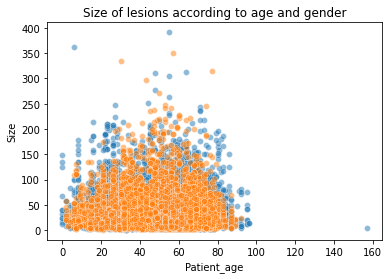

In [9]:

dl_df["alpha"] = np.where(dl_df.Patient_gender == "M", 0.5, 1)
ax = sns.scatterplot(x="Patient_age", y="Size",
                     data=dl_df[dl_df.alpha == 0.5], alpha=0.5)

sns.scatterplot(x="Patient_age", y="Size", data=dl_df[dl_df.alpha == 1], 
                alpha=0.5, ax=ax).set_title('Size of lesions according to age and gender')

In [10]:
df_count = dl_df.loc[dl_df['Coarse_lesion_type'] != -1]
"""removing lesion type -1 as it indicates test/val data and not a lesion
  type"""
fig = px.histogram(df_count, x="Coarse_lesion_type", width=750, height=400, 
                   title="Number of patients according to type of lesion",
                   labels={"Coarse_lesion_type": "Type of Lesion"}, 
                   color="Coarse_lesion_type")

fig.show()

####Where types of lesions are as follows:
####1: bone, 2: abdomen, 3: mediastinum, 4: liver, 5:lung,
####6: kidney, 7: soft tissue, and 8: pelvis

In [11]:
df_count = dl_df.groupby(['Coarse_lesion_type', 'Patient_gender']).size()
df_count = df_count.to_frame().reset_index()
df_count.columns = ['Coarse_lesion_type', 'Patient_gender','Count']
df_count = df_count.loc[df_count['Coarse_lesion_type'] != -1]
df_count.columns

Index(['Coarse_lesion_type', 'Patient_gender', 'Count'], dtype='object')

In [12]:
fig = px.bar(df_count, x='Coarse_lesion_type', y='Count',
             hover_data=['Count', 'Patient_gender'], color='Patient_gender',
             labels={'Count':'Number of Patients',
                     'Coarse_lesion_type':'Lesion Type'}, 
             height=400, width=650, 
             title="Number of patients according to lesion types and gender")
fig.show()

####Where types of lesions are as follows:
####1: bone, 2: abdomen, 3: mediastinum, 4: liver, 5:lung,
####6: kidney, 7: soft tissue, and 8: pelvis

## Extracting bounding boxes

In [13]:
dl_df['exists'] = dl_df['location'].map(os.path.exists)
dl_df = dl_df[dl_df['exists']].drop('exists', 1)
# extract the bounding boxes
dl_df['bbox'] = dl_df['Bounding_boxes'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1, 4)))
print('Found', dl_df.shape[0], 'patients with images')

Found 1350 patients with images


In [14]:
def masks(in_row):
    box_list = []
    for (start_x, start_y, end_x, end_y) in in_row['bbox']:
        box_list += [Rectangle((start_x, start_y), 
                         np.abs(end_x-start_x),
                         np.abs(end_y-start_y)
                         )]
    return box_list

Text(0.5, 1.0, 'Gender:F, Age:34.0')

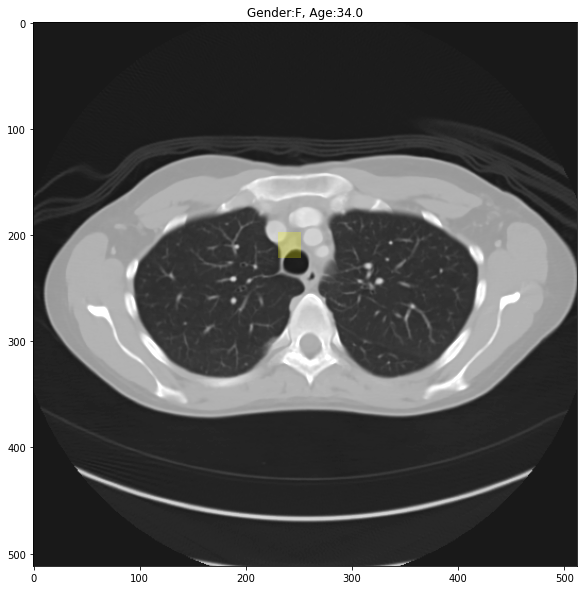

In [15]:
img_read = lambda x: imread(x).astype(np.float32)-32768

_, test_row = next(dl_df.sample(1, random_state=0).iterrows())
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
c_img = img_read(test_row['location'])
ax1.imshow(c_img, vmin = -1200, vmax = 600, cmap = 'gray')
ax1.add_collection(PatchCollection(masks(test_row), alpha = 0.25, facecolor = 'yellow'))
ax1.set_title('Gender:{Patient_gender}, Age:{Patient_age}'.format(**test_row))

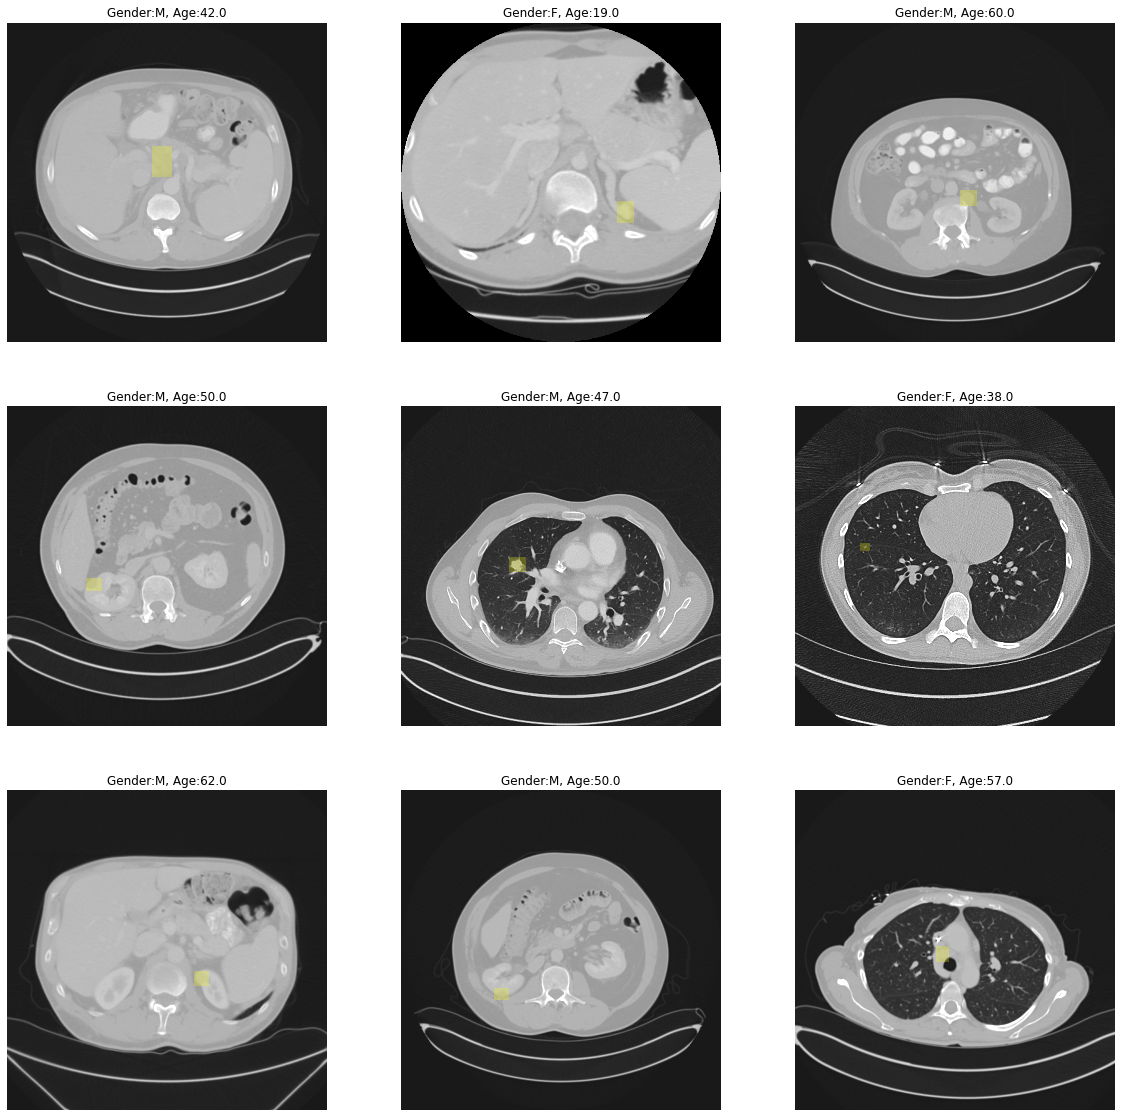

In [16]:
fig, m_axs = plt.subplots(3, 3, figsize = (20, 20))
for c_ax, (_, c_row) in zip(m_axs.flatten(), 
        dl_df.sample(50, random_state=100).iterrows()):
    
    c_img = img_read(c_row['location'])
    c_ax.imshow(c_img, vmin = -1200, vmax = 600, cmap = 'gray')
    c_ax.add_collection(PatchCollection(masks(c_row), alpha = 0.25, facecolor = 'yellow'))
    c_ax.set_title('Gender:{Patient_gender}, Age:{Patient_age}'.format(**c_row))
    c_ax.axis('off')

## Forming segmentations

In [17]:
def form_segments(in_img, in_row):
    yy, xx = np.meshgrid(range(in_img.shape[0]),
               range(in_img.shape[1]),
               indexing='ij')
    out_seg = np.zeros_like(in_img)
    for (start_x, start_y, end_x, end_y) in in_row['bbox']:
        c_seg = (xx<end_x) & (xx>start_x) & (yy<end_y) & (yy>start_y)
        out_seg+=c_seg
    return np.clip(out_seg, 0, 1).astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


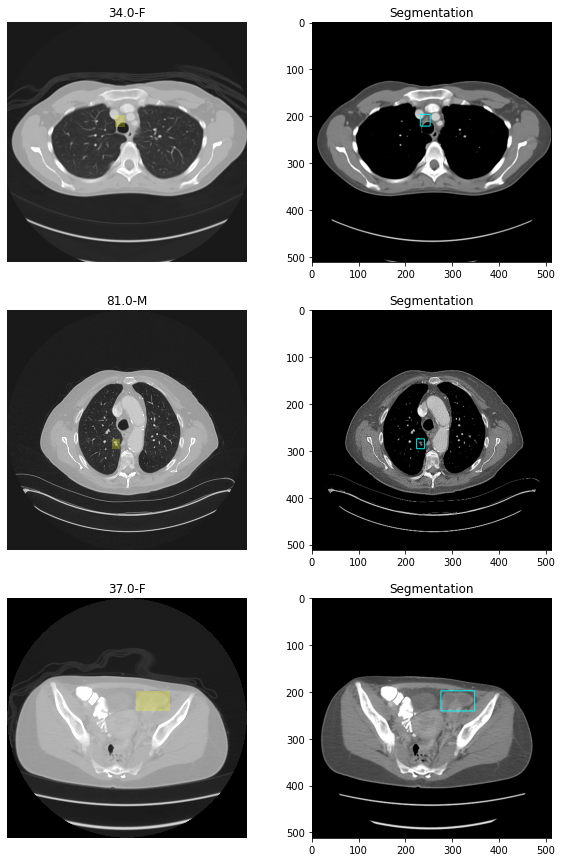

In [18]:
from skimage.segmentation import mark_boundaries
apply_softwindow = lambda x: (255*plt.cm.gray(0.5*np.clip((x-50)/350, -1, 1)+0.5)[:, :, :3]).astype(np.uint8)
fig, m_axs = plt.subplots(3, 2, figsize = (10, 15))
for (ax1, ax2), (_, c_row) in zip(m_axs, 
        dl_df.sample(50, random_state=0).iterrows()):
    
    c_img = img_read(c_row['location'])
    ax1.imshow(c_img, vmin = -1200, vmax = 600, cmap = 'gray')
    ax1.add_collection(PatchCollection(masks(c_row), alpha = 0.25, facecolor = 'yellow'))
    ax1.set_title('{Patient_age}-{Patient_gender}'.format(**c_row))
    ax1.axis('off')
    
    c_segs = form_segments(c_img, c_row).astype(int)
    ax2.imshow(mark_boundaries(image=apply_softwindow(c_img), 
                               label_img=c_segs,
                               color=(0,6,5),
                              mode='thick'))
    ax2.set_title('Segmentation')
    
fig.savefig('segmented_imgs.png', dpi = 300)

## Creating HDF5 from images, segmentations and image paths which are just file names in the csv

In [19]:
img_list = []
seg_list = []
path_list = []
from tqdm import tqdm_notebook
for (_, c_row) in tqdm_notebook(dl_df.iterrows()):
    c_img = img_read(c_row['location'])
    img_list+=[c_img]
    seg_list+=[form_segments(c_img, c_row).astype(bool)]
    path_list+=[c_row['File_name']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [20]:
from skimage.transform import resize
def smart_stack(in_list, *args, **kwargs):
    base_shape = in_list[0].shape
    return np.stack([x if x.shape==base_shape else resize(x, base_shape, preserve_range=True) for x in in_list], *args, **kwargs)

In [21]:
def _dsum(carr,  # type: np.ndarray
          cax  # type: int
          ):
    # type: (...) -> np.ndarray
    """
    Sums the values along all other axes but the current
    """
    return np.sum(carr, tuple(n for n in range(carr.ndim) if n is not cax))

def get_bbox(in_vol,
             min_val=0):
    # type: (np.ndarray, float) -> List[Tuple[int,int]]
    """
    Calculate a bounding box around an image in every direction
    """
    ax_slice = []
    for i in range(in_vol.ndim):
        c_dim_sum = _dsum(in_vol > min_val, i)
        wh_idx = np.where(c_dim_sum)[0]
        c_sl = sorted(wh_idx)
        if len(wh_idx) == 0:
            ax_slice += [(0, 0)]
        else:
            ax_slice += [(c_sl[0], c_sl[-1] + 1)]
    return ax_slice


def apply_bbox(in_vol,  # type: np.ndarray
               bbox_list,  # type: List[Tuple[int,int]]
               pad_values=False,
               padding_mode='edge'
               ):
    # type: (...) -> np.ndarray
    """
    Apply a bounding box to an image
    """

    if pad_values:
        # TODO test padding
        warnings.warn("Padded apply_bbox not fully tested yet", RuntimeWarning)
        n_pads = []  # type: List[Tuple[int,int]]
        n_bbox = []  # type: List[Tuple[int,int]]
        for dim_idx, ((a, b), dim_size) in enumerate(zip(bbox_list,
                                                         in_vol.shape)):
            a_pad = 0 if a >= 0 else -a
            b_pad = 0 if b < dim_size else b - dim_size + 1
            n_pads += [(a_pad, b_pad)]
            n_bbox += [(a + a_pad, b + a_pad)]  # adjust the box

        while len(n_pads)<len(in_vol.shape):
            n_pads += [(0,0)]
        # update the volume
        in_vol = np.pad(in_vol, n_pads, mode=padding_mode)
        # update the bounding box list
        bbox_list = n_bbox

    return in_vol.__getitem__([slice(a, b, 1) for (a, b) in bbox_list])


def autocrop(in_vol,  
             min_val  
             ):
    # type (...) -> np.ndarray
    """
    Perform an autocrop on an image by keeping all the points above a value
    """
    return apply_bbox(in_vol, get_bbox(in_vol,min_val=min_val))

In [22]:
import h5py
with h5py.File('deeplesion.h5', 'w') as h:
    h.create_dataset('image', data=np.expand_dims(smart_stack(img_list, 0), -1), 
                     compression = 5)    
    h.create_dataset('mask', data=np.expand_dims(smart_stack(seg_list, 0), -1).astype(bool), 
                     compression = 5)    
    h.create_dataset('file_name', data=[x.encode('ascii') for x in path_list], 
                     compression = 0)   

In [23]:
# check the file

with h5py.File('deeplesion.h5', 'r') as h:
    for k in h.keys():
        print(k, h[k].shape, h[k].dtype, h[k].size/1024**2)

file_name (1350,) |S20 0.0012874603271484375
image (1350, 512, 512, 1) float32 337.5
mask (1350, 512, 512, 1) bool 337.5


## Opening the HDF5 file

In [24]:
%matplotlib inline
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import zipfile as zf
import numpy as np
import h5py
from keras.utils.io_utils import HDF5Matrix

base_h5_dir = 'drive/My Drive/'

In [25]:
h5_path = os.path.join(base_h5_dir, 'deeplesion.h5')
with h5py.File(h5_path, 'r') as h:
    print(list(h.keys()))
    for k in ['image', 'mask']:
        print(k, h[k].shape, h[k].dtype)
    base_shape = h['image'].shape

['file_name', 'image', 'mask']
image (1350, 512, 512, 1) float64
mask (1350, 512, 512, 1) bool


In [26]:
ct_window_func = lambda x: np.clip((x+175.0)/275, -1, 1)
get_xyf = lambda s, e: (HDF5Matrix(h5_path, 'image', start=s, end=e, normalizer=ct_window_func), 
                       HDF5Matrix(h5_path, 'mask', start=s, end=e),
                       HDF5Matrix(h5_path, 'file_name', start=s, end=e)
                      )
train_split = 0.7
cut_val = int(base_shape[0]*train_split)
train_x, train_y, train_paths = get_xyf(0, cut_val)
test_x, test_y, test_paths = get_xyf(cut_val, None)
print(train_x.shape, test_x.shape)

Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.
(944, 512, 512, 1) (406, 512, 512, 1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/io_utils.py:89: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



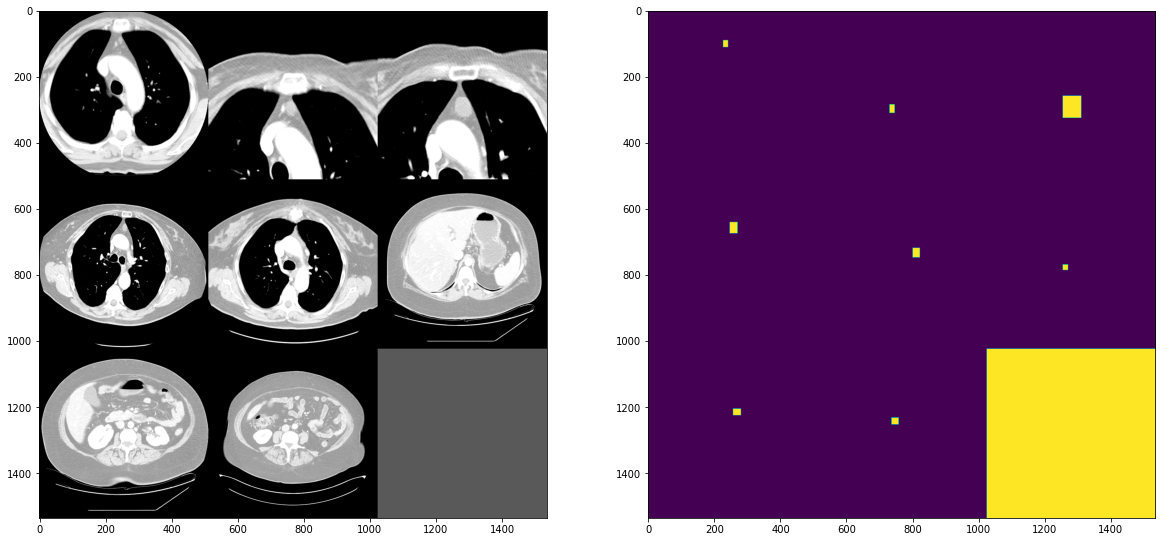

In [27]:
from skimage.util import montage as montage
t_x, t_y = train_x[:8], train_y[:8]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'gray')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [28]:
# we dont need full resolution images so we can just use a downsampled version
class DownsampledHDF5Matrix(HDF5Matrix):
    def __init__(self, datapath, dataset, downscale_factor, start=0, end=None, normalizer=None):
        ds_func = lambda x: x[:, ::downscale_factor, ::downscale_factor, :]
        ds_norm = ds_func if normalizer is None else lambda x: ds_func(normalizer(x))
        self.downscale_factor = downscale_factor
        super(DownsampledHDF5Matrix, self).__init__(datapath, dataset, start=start, end=end, normalizer=ds_norm)
        t_val = self[0:1]
        self._base_shape = t_val.shape[1:]
        self._base_dtype = t_val.dtype
    
    @property
    def shape(self):
        """Gets a numpy-style shape tuple giving the dataset dimensions.
        # Returns
            A numpy-style shape tuple. (self.data.shape[1]//self.downscale_factor, self.data.shape[2]//self.downscale_factor, self.data.shape[3])
        """
        return (self.end - self.start,) + self._base_shape
    
    @property
    def dtype(self):
        """Gets the datatype of the dataset.
        # Returns
            A numpy dtype string.
        """
        return self._base_dtype

(406, 512, 512, 1) (406, 128, 128, 1)


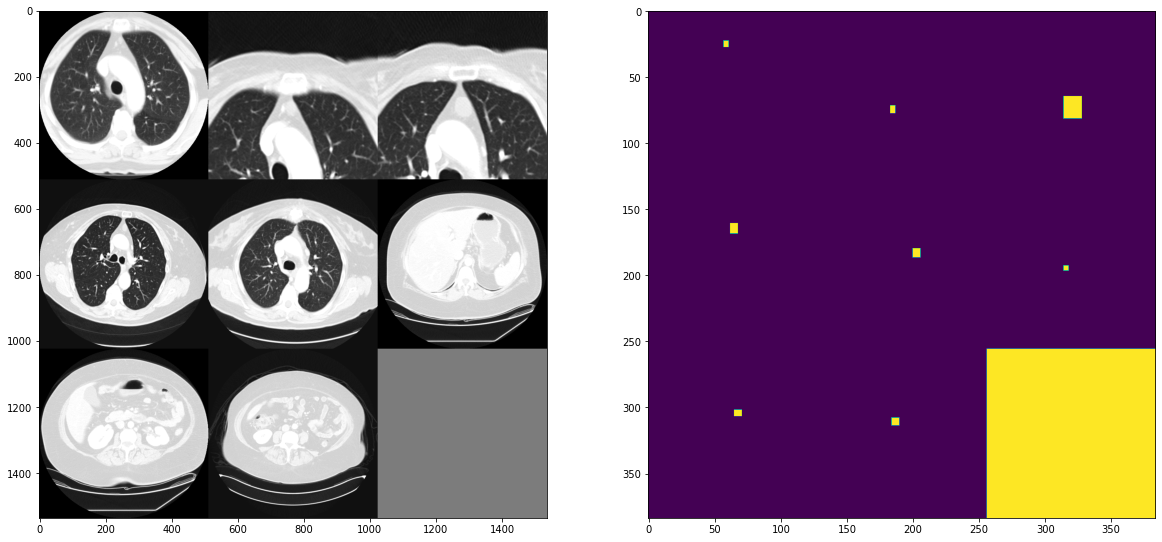

In [29]:
ct_window_func = lambda x: np.clip((x+500.0)/600, -1, 1)
get_xyf = lambda s, e: (HDF5Matrix(h5_path, 'image', start=s, end=e, normalizer=ct_window_func), 
                       DownsampledHDF5Matrix(h5_path, 'mask', downscale_factor=4, start=s, end=e),
                       [x.decode() for x in HDF5Matrix(h5_path, 'file_name', start=s, end=e)[:]]
                      )
train_split = 0.7
cut_val = int(base_shape[0]*train_split)
train_x, train_y, train_paths = get_xyf(0, cut_val)
test_x, test_y, test_paths = get_xyf(cut_val, None)
print(test_x.shape, test_y.shape)
t_x, t_y = train_x[:8], train_y[:8]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'gray')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [30]:
dl_df = dl_df[dl_df['File_name'].isin(train_paths+test_paths)]
dl_df['training'] = dl_df['File_name'].isin(train_paths)
dl_df.sample(3)

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test,location,Size,alpha,bbox,training
262,000052_02_01_026.png,52,2,1,26,"217.806, 277.825, 198.709, 225.601, 204.165, 2...","193.709, 220.601, 222.806, 282.825","55.6068, 9.41841","0.396667, 0.475277, 0.44334",3,0,"20, 32","0.781, 0.781, 5","512, 512","-160, 240",M,58.0,3,drive/My Drive/minideeplesion/000052_02_01/026...,55.6068,0.5,"[[193.709, 220.601, 222.806, 282.825]]",True
381,000062_09_01_063.png,62,9,1,63,"253.815, 194.825, 288.226, 195.371, 264.739, 1...","248.815, 172.346, 293.226, 209.656","34.4155, 27.3105","0.545038, 0.392276, 0.597722",-1,0,"57, 85","0.782, 0.782, 5","512, 512","-175, 275",M,70.0,1,drive/My Drive/minideeplesion/000062_09_01/063...,34.4155,0.5,"[[248.815, 172.346, 293.226, 209.656]]",True
352,000060_06_01_064.png,60,6,1,64,"323.35, 240.279, 284.072, 246.712, 297.278, 22...","279.072, 221.735, 328.35, 257.469","39.8015, 26.0769","0.606263, 0.569221, 0.627649",2,0,"58, 70","0.9375, 0.9375, 5","512, 512","-175, 275",M,68.0,2,drive/My Drive/minideeplesion/000060_06_01/064...,39.8015,0.5,"[[279.072, 221.735, 328.35, 257.469]]",True


## Defining the model

In [33]:
from keras.layers import Input, Activation, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, BatchNormalization, Cropping2D, ZeroPadding2D, SpatialDropout2D
from keras.layers import Conv2DTranspose, Dropout, GaussianNoise
from tensorflow.keras.models import Model
from keras import backend as K

def up_scale(in_layer):
    filt_count = in_layer.shape[-1]
    return Conv2DTranspose(filt_count//2+2, kernel_size = (2,2), 
                           strides = (2,2), padding = 'same')(in_layer)
def up_scale_fancy(in_layer):
    return UpSampling2D(size=(2,2))(in_layer)

input_layer = Input(shape=train_x.shape[1:])
sp_layer = GaussianNoise(0.1)(input_layer)
bn_layer = BatchNormalization()(sp_layer)
c1 = Conv2D(filters=8, kernel_size=(5,5), activation='relu', padding='same')(bn_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
# Experimented with this section
l = SpatialDropout2D(0.25)(c4)
dil_layers = [l]
for i in [2, 4]:
    dil_layers += [Conv2D(16,
                          kernel_size = (3, 3), 
                          dilation_rate = (i, i), 
                          padding = 'same',
                         activation = 'relu')(l)]
l = concatenate(dil_layers)

l = SpatialDropout2D(0.2)(concatenate([up_scale(l), c3], axis=-1))
l = Conv2D(filters=128, kernel_size=(2,2), activation='linear', padding='same')(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=16, kernel_size=(2,2), activation='linear', padding='same')(l)
l = Cropping2D((4,4))(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)

l = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
output_layer = ZeroPadding2D((4,4))(l)

seg_model = Model(input_layer, output_layer)
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 1)  4           gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  208         batch_normalization[0][0]        
______________________________________________________________________________________________

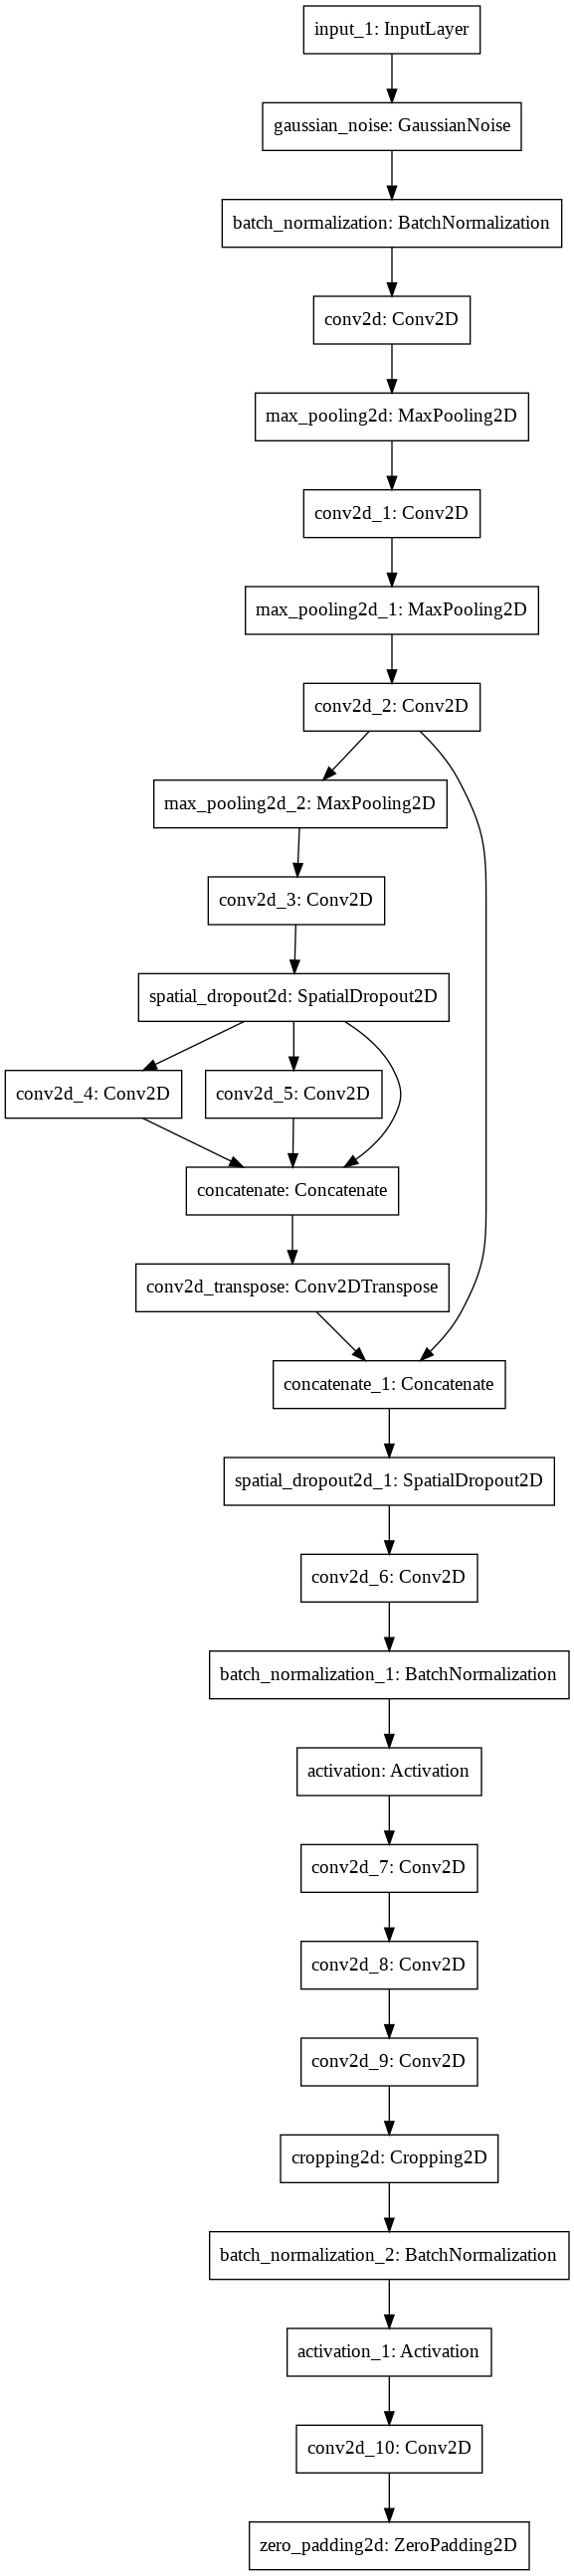

In [34]:
tf.keras.utils.plot_model(seg_model)

In [35]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [36]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

## Augmenting train data

In [37]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5.5, 
                  width_shift_range = 0.02, 
                  height_shift_range = 0.04, 
                  shear_range = 0.01,
                  zoom_range = [1.9, 1.30],  
                  brightness_range = [0.7, 1.0],
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)
def train_gen(batch_size = 16, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        batch_count = train_x.shape[0]//batch_size
        batch_id = np.random.permutation(range(0, train_x.shape[0]-batch_size, batch_size))
        for c_idx in batch_id:
            g_x = image_gen.flow(train_x[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=True)
            g_y = label_gen.flow(train_y[c_idx:(c_idx+batch_size)], batch_size = batch_size, seed = seed, shuffle=True)
            yield next(g_x)/255.0, next(g_y)

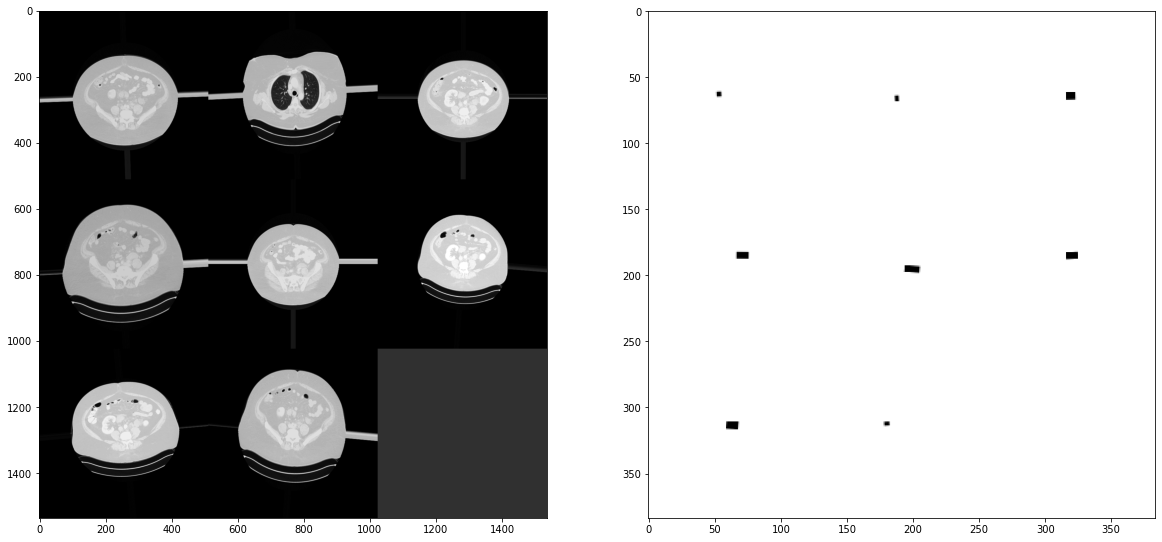

In [38]:
cur_gen = train_gen(8)
t_x, t_y = next(cur_gen)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap='gray')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')

## Fitting and evaluating the model

In [39]:
batch_size = 32
loss_history = [seg_model.fit_generator(train_gen(batch_size), 
                             steps_per_epoch=train_x.shape[0]//batch_size, 
                             epochs=40, 
                             validation_data=(test_x, test_y),
                             callbacks=callbacks_list,
                            workers=1, use_multiprocessing=False)]

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
29/29 [==============================] - ETA: 0s - loss: -0.0084 - dice_coef: 0.0084 - binary_accuracy: 0.7810 - true_positive_rate: 0.8660WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.

Epoch 00001: val_dice_coef improved from -inf to 0.01434, saving model to seg_model_weights.best.hdf5
29/29 [==============================] - 45s 2s/step - loss: -0.0084 - dice_coef: 0.0084 - binary_accuracy: 0.7810 - true_positive_rate: 0.8660 - val_loss: -0.0143 - val_dice_coef: 0.0143 - val_binary_accuracy: 0.5754 - val_true_positive_rate: 0.9514 - lr: 1.0000e-04
Epoch 2/40
29/29 [==============================] - ETA: 0s - loss: -0.0102 - dice_coef: 0.0102 - binary_accuracy: 0.7976 - true_positive

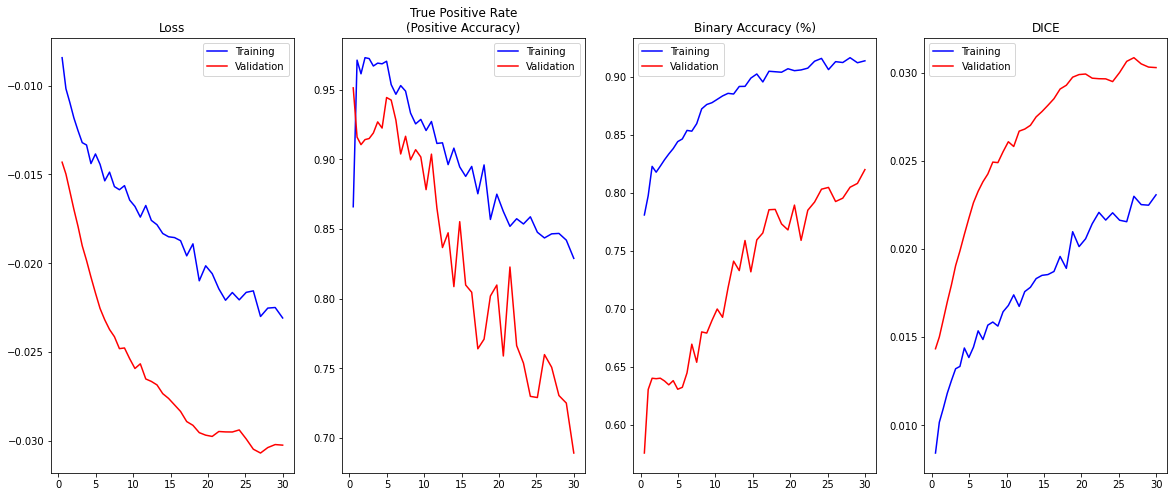

In [40]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [41]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

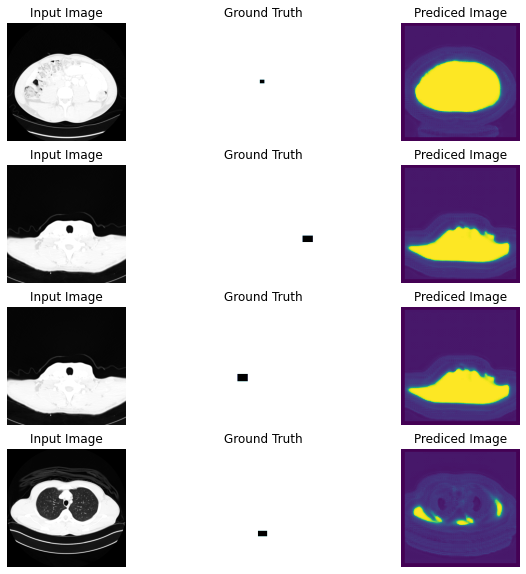

In [42]:
from sklearn.metrics import confusion_matrix
fig, m_axs = plt.subplots(4,3, figsize = (10, 10))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for idx, (ax1, ax2, ax3) in enumerate(m_axs):
    ix = test_x[idx:idx+1]
    iy = test_y[idx:idx+idx+1]
    p_image = seg_model.predict(ix)
    ax1.imshow(ix[0,:,:,0], cmap = 'gray')
    ax1.set_title('Input Image')
    ax2.imshow(iy[0,:,:,0], vmin = 0, vmax = 1, cmap = 'bone_r' )
    ax2.set_title('Ground Truth')
    ax3.imshow(p_image[0,:,:,0], vmin = 0, vmax = 1, cmap = 'viridis' )
    ax3.set_title('Prediced Image')

In [48]:
results = seg_model.evaluate(test_x,test_y,batch_size=32)

13/13 [==============================] - 6s 490ms/step - loss: -0.0307 - dice_coef: 0.0309 - binary_accuracy: 0.7954 - true_positive_rate: 0.7508


In [56]:
print("test loss:", results[0])
print("test dice:", results[1])
print("test binary accuracy:", results[2])
print("test true positive rate:", results[3])

test loss: -0.030674900859594345
test dice: 0.03085225820541382
test binary accuracy: 0.7954323887825012
test true positive rate: 0.7507731318473816


In [51]:
seg_model.metrics_names

['loss', 'dice_coef', 'binary_accuracy', 'true_positive_rate']

# To be used for generating images for Water Segmentation model


In [56]:
img_read = lambda x: imread(x).astype(np.float32)-32768

_, test_row = next(dl_df.sample(1, random_state=86).iterrows())
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
c_img = img_read(test_row['location'])
ax1.imshow(c_img, vmin = -1200, vmax = 600, cmap = 'gray')

# This line may be excluded for generating image without bounding boxes of lesions
ax1.add_collection(PatchCollection(masks(test_row), alpha = 0.25, facecolor = 'yellow'))

ax1.set_title('{File_name} Gender:{Patient_gender}, Age:{Patient_age}, File:{File_name}'.format(**test_row))
print('{File_name}'.format(**test_row))
fig.savefig('/content/drive/My Drive/unsegmented_img.png', dpi = 300)